In [4]:
import pandas as pd
import matplotlib.pyplot as plt

import heartpy as hp
from hrvanalysis import *
# from pyEDA.main import *

from core.main import *
hr_channel = 38
sample_rate = 128
data = extract_data_by_video()
video_info = pd.read_csv("metadata_csv/video_list.csv")
# plt.figure(figsize=(12,4))
# plt.plot(x)
# plt.show()

True


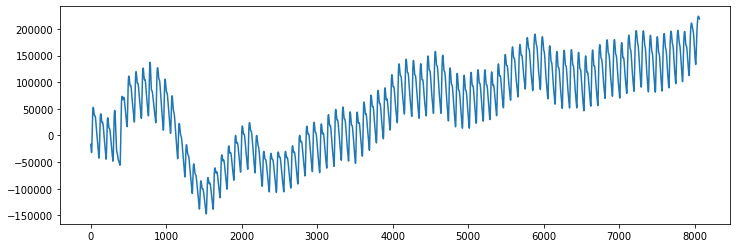

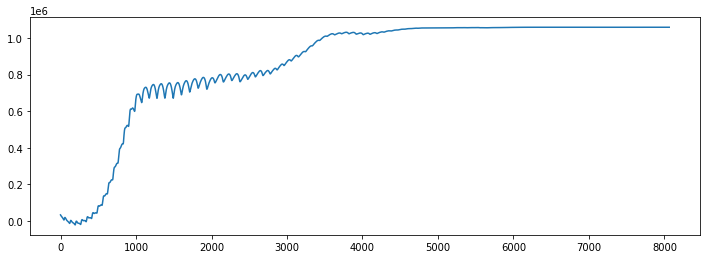

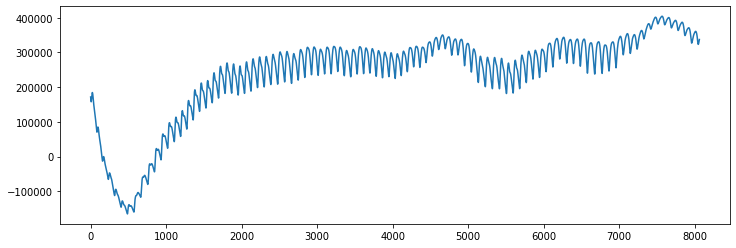

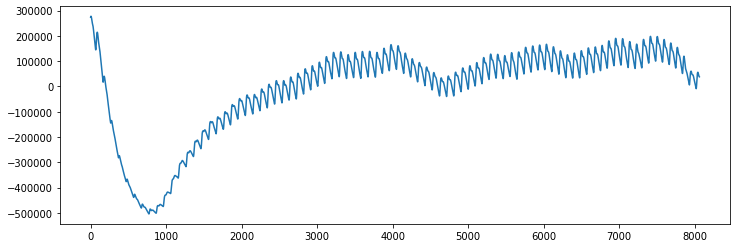

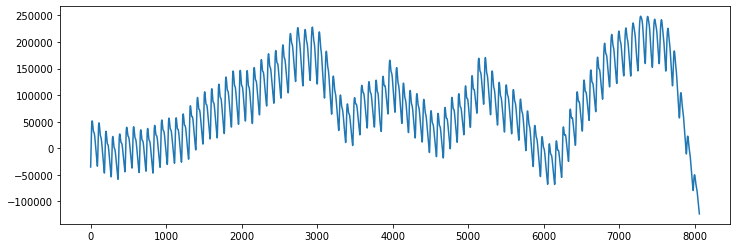

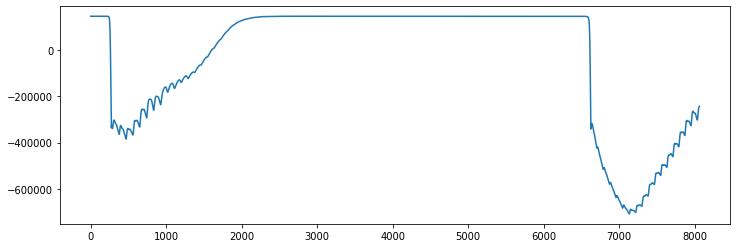

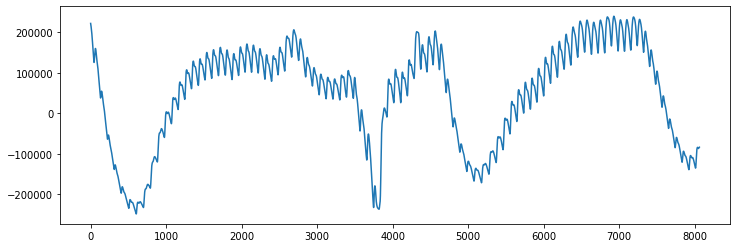

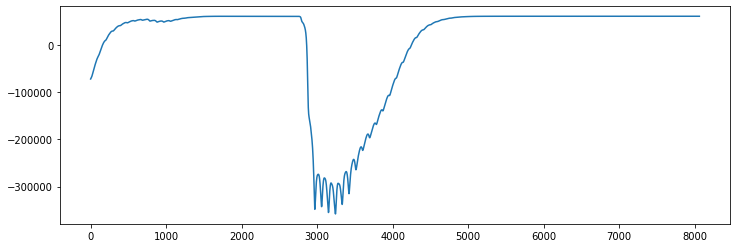

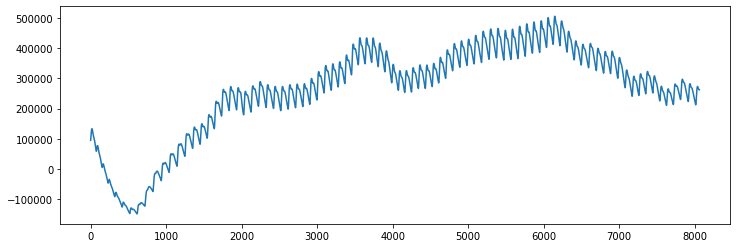

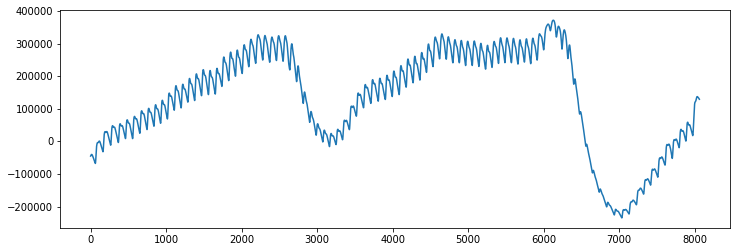

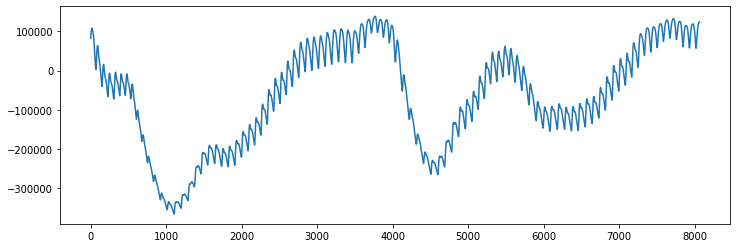

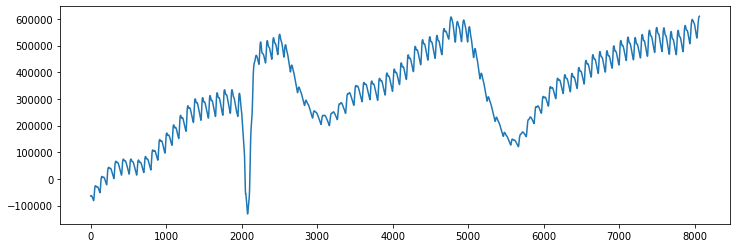

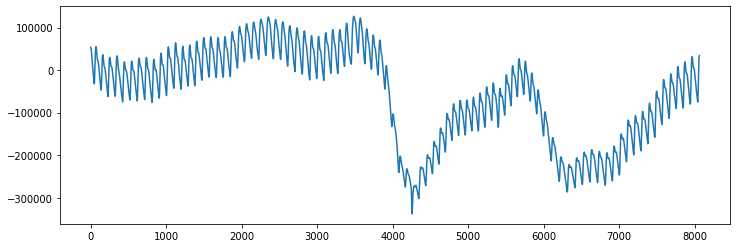

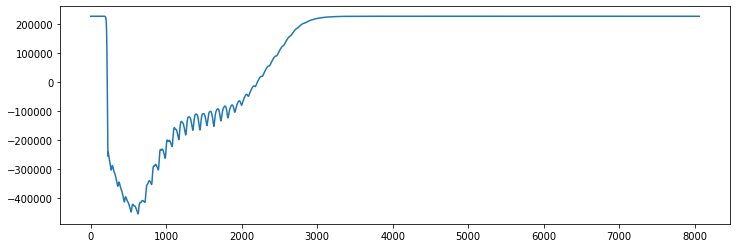

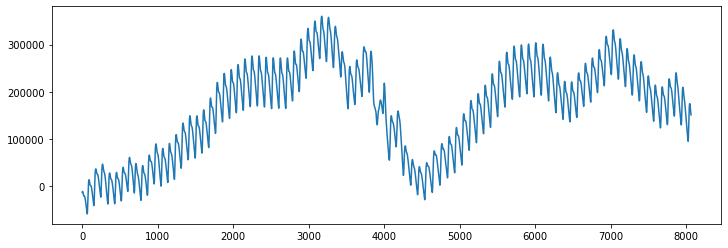

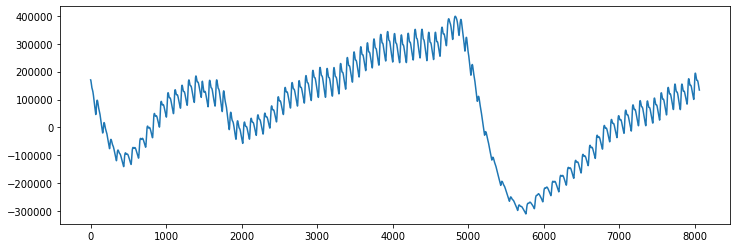

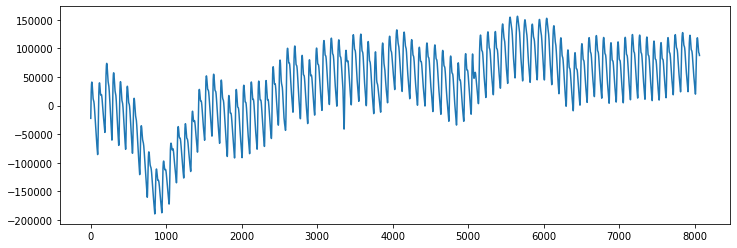

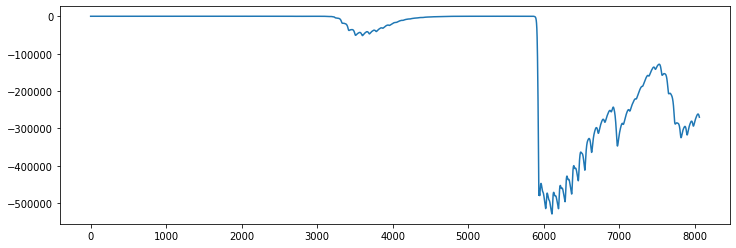

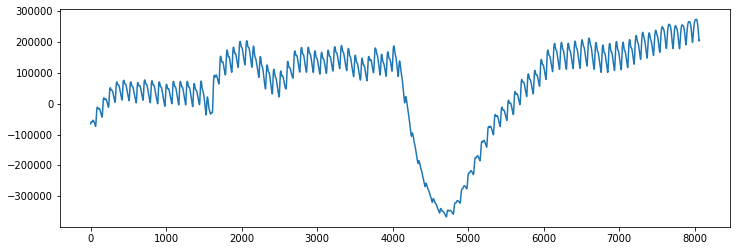

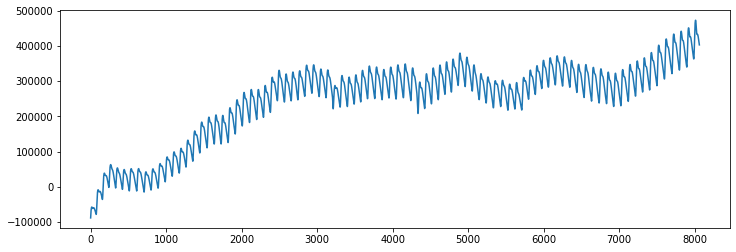

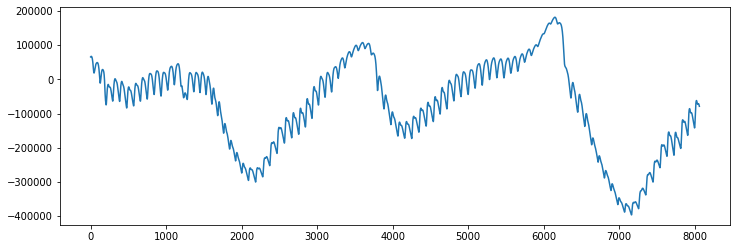

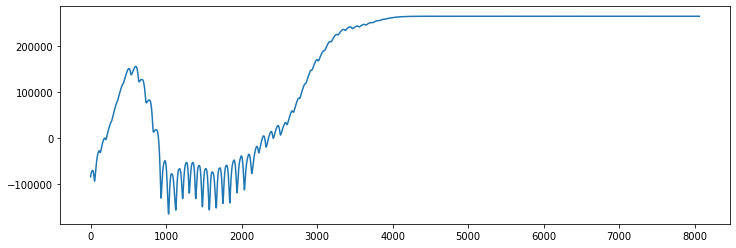

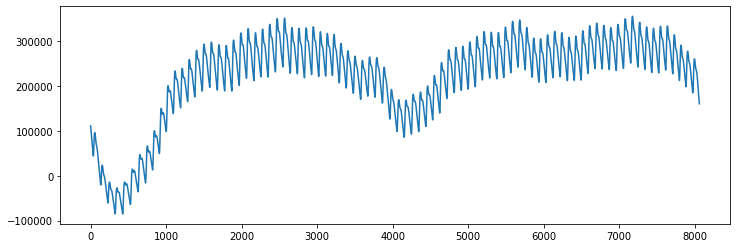

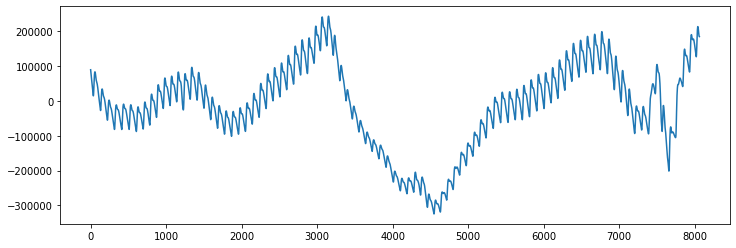

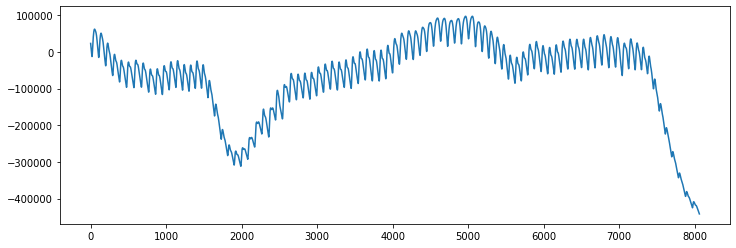

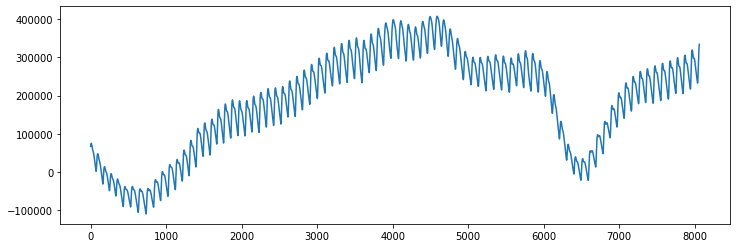

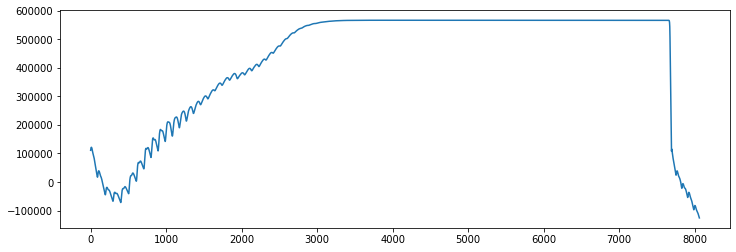

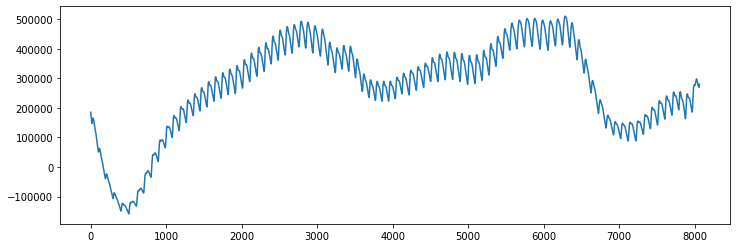

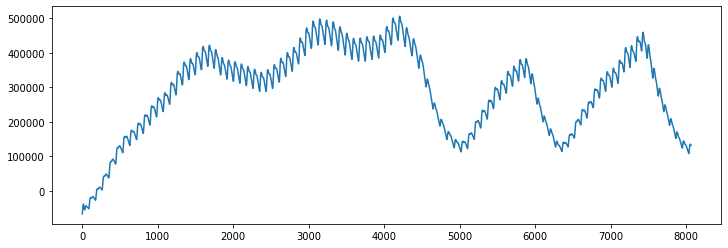

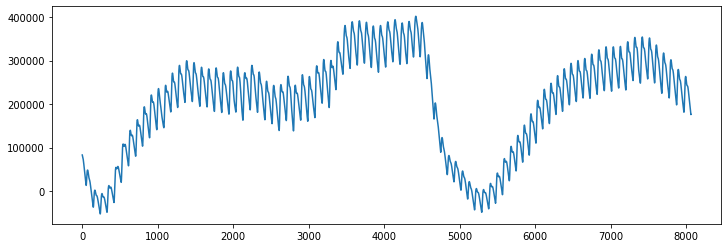

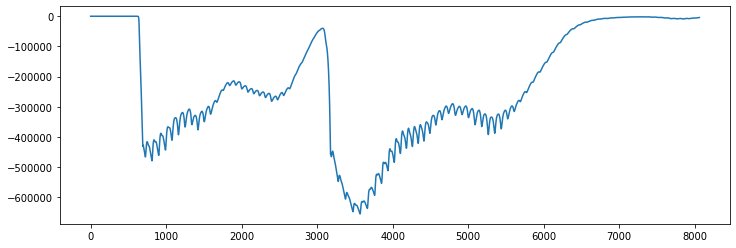

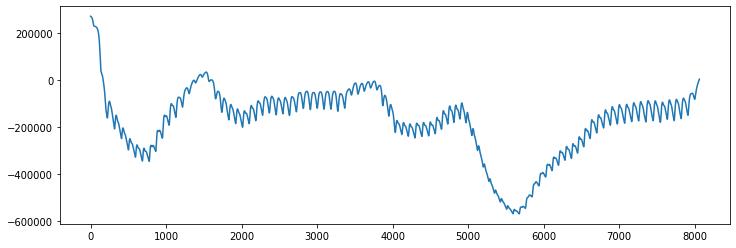

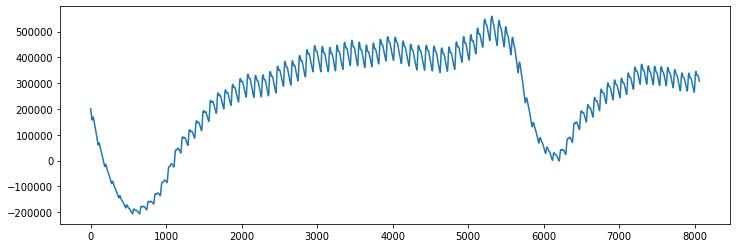

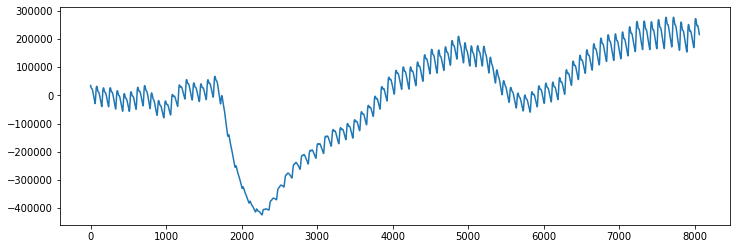

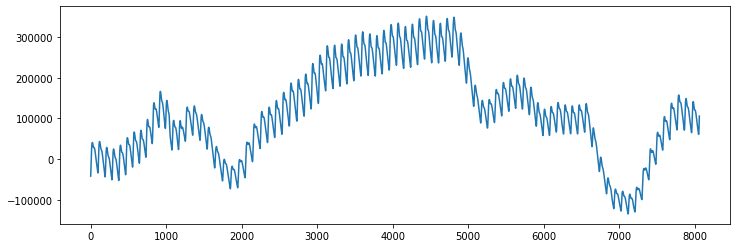

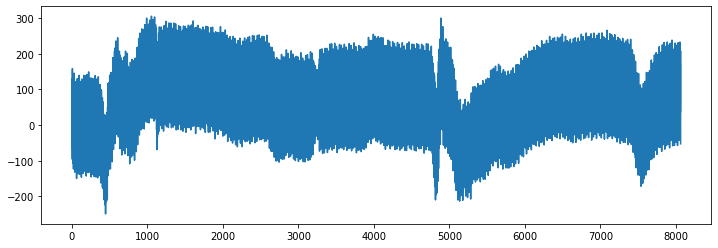

In [7]:
import heartpy as hp
import matplotlib.pyplot as plt
import numpy as np
eda_channel = 36
section = data.loc[(data['participant'] == 22) & (data['channel_id'] == eda_channel)]
X_input = section['channel_data'].tolist()
for x in X_input:
    x = np.array(x)
    # print(x)
#     wd, m = hp.process(x, sample_rate = 100.0)
#     hp.plotter(wd, m)
    plt.figure(figsize=(12,4))
    plt.plot(x)
    plt.show()
    break


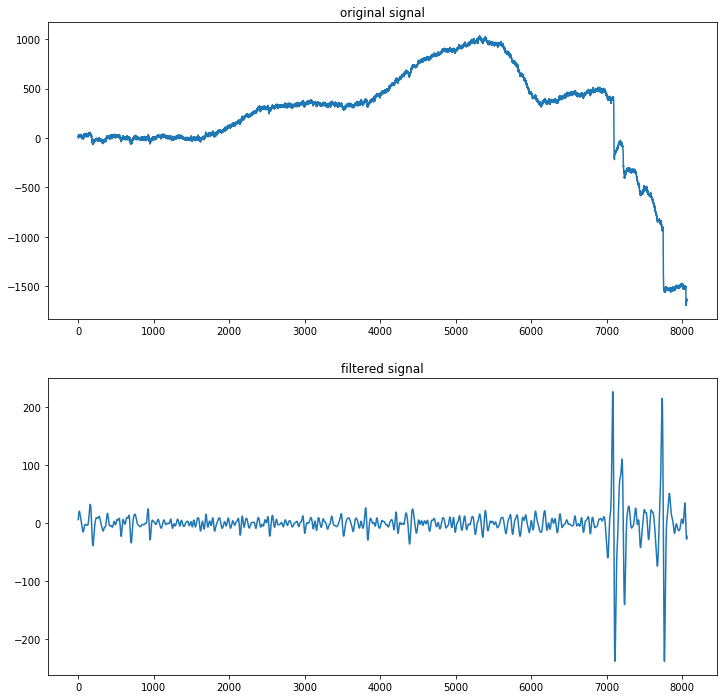

d:\miniconda3\lib\site-packages\numpy\ma\core.py:5243: RuntimeWarning: Mean of empty slice.
  result = super(MaskedArray, self).mean(axis=axis,
d:\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [5]:
# check user 13; seems to cause many Nan in hr analysis
hr_analysis_issues = {25: [5], 26: [9, 22]}
section = data.loc[(data['video'] == 9) & (data['channel_id'] == hr_channel)]
X_input = section['channel_data'].tolist()
# heart_rate_input = [list(get_time_domain_features(x).values()) for x in X_input]

heart_rate_input = []
x = X_input[26]
filtered = hp.filter_signal(x, [0.81, 3.5], sample_rate=sample_rate,
                    order=3, filtertype='bandpass')

plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.plot(x[0:int(240 * sample_rate)])
plt.title('original signal')
plt.subplot(212)
plt.plot(filtered[0:int(240 * sample_rate)])
plt.title('filtered signal')
plt.show()

wd, m = hp.process(filtered, sample_rate = sample_rate, bpmmax=220)

In [ ]:
feature_names = []
results_frame = {}
has_nan = []
for video_id in range(40):
    # process HEART RATE data
    section = data.loc[(data['video_id'] == video_id) & (data['channel_id'] == hr_channel)]
    X_input = section['channel_data'].tolist()
    # heart_rate_input = [list(get_time_domain_features(x).values()) for x in X_input]

    heart_rate_input = []
    for participant, x in enumerate(X_input):
        filtered = hp.filter_signal(x, [0.7, 3.5], sample_rate=sample_rate,
                            order=3, filtertype='bandpass')
        wd, m = hp.process(filtered, sample_rate = sample_rate)
        filtered_input = list(m.values())
        # filtered_input = np.nan_to_num(filtered_input)

        if np.isnan(np.sum(filtered_input)):
            has_nan.append(str(video_id) + '_' + str(participant))

        heart_rate_input.append(filtered_input)
        if video_id == 0 and participant < 10:
            hp.plotter(wd, m, title = 'zoomed in section', figsize=(12,6))
            hp.plot_poincare(wd, m)
            plt.show()

    if not feature_names:
        _, feats = hp.process(X_input[0], sample_rate = sample_rate)
        feature_names = list(feats.keys())
        results_frame = {x:[] for x in ['video_name', 'emotion', 'test_score']+feature_names}

    row = video_info[video_info['Experiment_id'] == (video_id+1)].iloc[0]
    video_name = row['Artist'] + " - " + row['Title']
    for emotion in ['Valence', 'Arousal', 'Dominance', 'Liking']:
        target_emotion = np.array(section[emotion].tolist())
        test_score, importance = run_test(heart_rate_input, target_emotion, feature_names)
        results_frame['video_name'].append(video_name)
        results_frame['emotion'].append(emotion)
        results_frame['test_score'].append(test_score)
        for i, f in enumerate(feature_names):
            results_frame[f].append(importance[i])
    print(video_id)
results_frame = pd.DataFrame(results_frame)
print(results_frame)

In [ ]:
heart_frame = pd.DataFrame(results_frame)
print(heart_frame.groupby('emotion').mean())
plot_labels = {f: heart_frame[f].mean() for f in feature_names}
# ax = pd.DataFrame(plot_labels, index=feature_names).plot(figsize=(5,5)).bar(rot=0)